## PREDICTIVE MODELLING OF SHEEP WEIGHTS USING MULTILAYER PERCEPTRON

In [1]:
# The following libraries are for data preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
 
# The libraries below are Pytorch libraries for the linear regression modelling
import torch
from torch.nn import Linear    # linear function
from torch.nn import ReLU      # relu activation function fot transformation
from torch.optim import Adam   # For optimizing the loss function
from torch.nn import MSELoss
import torch.nn.functional as F
 
# Graphs
import seaborn as sns
import matplotlib.pyplot as plt
 
# visualization
from torchviz import make_dot, make_dot_from_trace
from torchsummary import summary

 # Data Importation

**PLEASE NOTE**
* Name your data **dataset**



In [2]:
data = pd.read_excel('dataset.xlsx')
data.rename(columns={'male/female':'gender'},inplace=True)

data.head()

C:\Users\DELL\AppData\Local\Temp/ipykernel_7596/3662284863.py:1: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  data = pd.read_excel('dataset.xlsx')


,Serial number,breed,gender,Date of determination,Chest circumference of pig,Abdominal circumference of pigs,Waist circumference of pig,date of birth,Weight measurement,Length of pig,The height of a pig
0,1,S21,female,2016-04-22,110,115,107,2015-10-12,113.5,120,0
1,2,S21,female,2016-04-22,105,116,106,2015-10-13,111.4,119,0
2,3,S21,female,2016-04-22,109,120,104,2015-10-11,114.6,125,0
3,4,S21,female,2016-04-22,105,112,100,2015-10-13,111.8,123,0
4,5,S21,female,2016-04-22,107,116,106,2015-10-16,114.2,118,0


## Summary Statistics
The visualizations below shows the distribution of gender and breed of pigs in the dataset.The are 5438 females and  males in the dataset. 8068 of the pigs are of breed S21 and 1912 are S23.

In [4]:
# Counts of S21 and S23 pigs in the dataset
data['breed'].value_counts()

S21    8068
S23    1912
Name: breed, dtype: int64

In [5]:
# Counts of male and female pigs in the dataset
data['gender'].value_counts()

female    5438
male      4542
Name: gender, dtype: int64

In [6]:
# Average weight of female and male pigs
data['Weight measurement'].groupby(data['gender']).mean()

gender
female    108.457613
male      113.149665
Name: Weight measurement, dtype: float64

In [7]:
# Average weight of S21 and S23 pigs
data['Weight measurement'].groupby(data['breed']).mean()

breed
S21    111.712219
S23    105.870345
Name: Weight measurement, dtype: float64

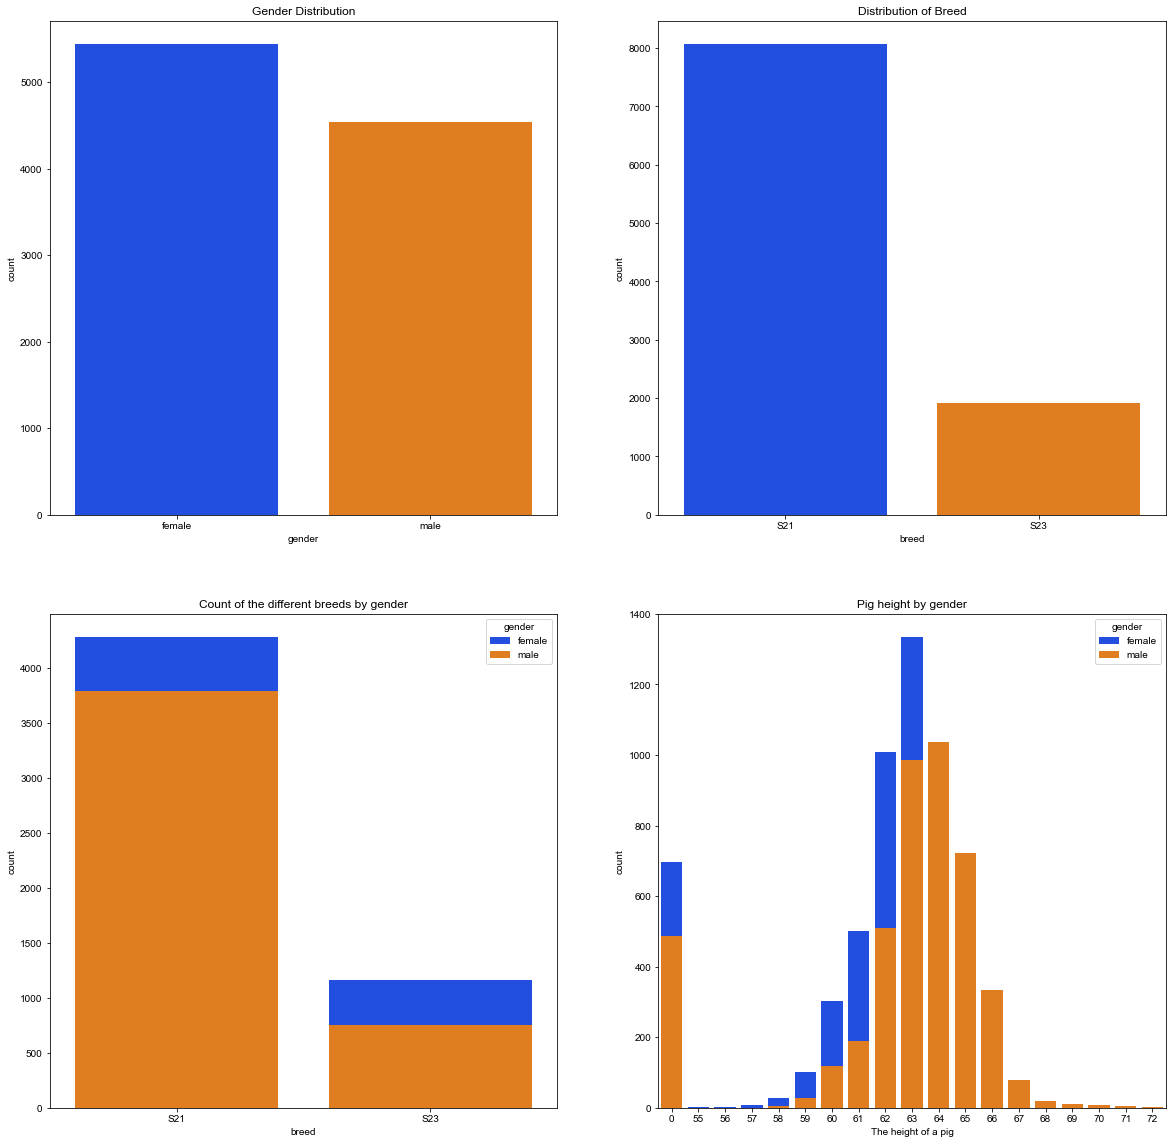

In [8]:
# Visualization of the features of the pigs
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
sns.countplot(x='breed',data=data, hue='gender',palette=sns.color_palette("bright", 2),dodge=False,
              ax=ax[1][0]).set_title("Count of the different breeds by gender")
sns.countplot(x='The height of a pig', data=data, hue='gender',palette=sns.color_palette("bright", 2),dodge=False,
              ax=ax[1][1]).set_title("Pig height by gender")
sns.countplot(x='gender', data=data,palette=sns.color_palette("bright", 4),dodge=False,
              ax=ax[0][0]).set_title("Gender Distribution")

sns.countplot(x='breed', data=data,palette=sns.color_palette("bright", 2),dodge=False,ax=ax[0][1],
             ).set_title("Distribution of Breed")#ax=ax[1][1]
sns.set(font_scale=2) 
plt.show()


# Data Cleaning
This included,
* Creation of a new column called **age in days** which was the difference between the date of determination and date of birth
* Conversion of the gender and breed types to numerical variables (OneHot Encoding)
* Imputation of missing values in the **pig height** with the median height

In [9]:
data['Date of determination']=pd.to_datetime(data['Date of determination'])
data['date of birth']=pd.to_datetime(data['date of birth'])
cleaned_data=pd.concat([data,pd.get_dummies(data['gender'])],axis=1)
cleaned_data=pd.concat([cleaned_data,pd.get_dummies(data['breed'])],axis=1)
cleaned_data['age in days']=(cleaned_data['Date of determination']-cleaned_data['date of birth']).dt.days
cleaned_data.drop(['Serial number','breed','gender','Date of determination','date of birth',],axis=1,inplace=True)

median=cleaned_data[cleaned_data['The height of a pig']!=0]['The height of a pig'].median()
cleaned_data['The height of a pig']=[median if item==0 else item for item in cleaned_data['The height of a pig']]

cleaned_data.head()

,Chest circumference of pig,Abdominal circumference of pigs,Waist circumference of pig,Weight measurement,Length of pig,The height of a pig,female,male,S21,S23,age in days
0,110,115,107,113.5,120,63.0,1,0,1,0,193
1,105,116,106,111.4,119,63.0,1,0,1,0,192
2,109,120,104,114.6,125,63.0,1,0,1,0,194
3,105,112,100,111.8,123,63.0,1,0,1,0,192
4,107,116,106,114.2,118,63.0,1,0,1,0,189


# MODEL1: PREDICTION OF WEIGHT USING ALL FEATURES
**Features**<br>
The features or parameters selected for the modelling are,
* Chest circumference of pig
* Abdominal circumference of pigs
* Waist circumference of pig
* Length of pig
* The height of a pig
* Male
* Female
* S21. Type of breed
* S23. Type of breed
* Age in days

**Label**
* Weight measurement

## Splitting dataset into traning and testing set
In this section, 70% of the dataset is used as **Train Set** for training the linear regression model,15% is used as **Validation Set** and 15% as the **TEST SET** is used for testing.<br>
The individual datasets are then converted into tensors to be utilized by the Pytorch Framework

In [10]:

# Splitting cleaned_data into training and test sets

X1=cleaned_data.drop('Weight measurement',axis=1)
y=np.array(cleaned_data['Weight measurement'])
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=6)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=6)


# Converting numpy arrays to tensors 

X_train = torch.from_numpy(X_train.values.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_train = y_train.view(y_train.shape[0], 1)

X_val=torch.from_numpy(X_val.values.astype(np.float32))
y_val = torch.from_numpy(y_val.astype(np.float32))
y_val = y_val.view(y_val.shape[0], 1)

X_test=torch.from_numpy(X_test.values.astype(np.float32))



# Modelling
This model is a 3 -layered Multilayer Perceptron (MLP) with the input layer, 2nd and output layer being linear. <br>
The model utilizes two Relu activation functions in the hidden layers. 

In [11]:
num_samples, num_features = X_train.shape
#input_size = num_features


class MLP(torch.nn.Module):

  def __init__(self, num_features):
    super(MLP, self).__init__()
    self.fc1 = Linear(num_features, 5) # Input layer
    self.fc2 = Linear(5, 6)          # 1st Hidden layer with 5 neurons
    self.fc3 = Linear(6, 1)          # Output layer

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return self.fc3(x)              # Output layer with 1 neuron

model_1 = MLP(num_features)
#summary(model_1, input_size=(X_train.shape))


# Training the model


In [12]:
model1_criterion = MSELoss()                            # Evaluation metric: Mean Squared Error
model1_optimizer = Adam(model_1.parameters(), lr=0.01)    # model1_optimizer Adam

# enumerate epochs
model1_time_step,model1_training_loss,model1_validation_loss=[],[],[]
epochs=300
for epoch in range(epochs):                      # Number of Epochs is 300
    model_1.train()
    # clear the gradients
    model1_optimizer.zero_grad()
    
    # compute the model output
    model1_prediction = model_1(X_train)
    
    # calculate training loss
    model1_loss = model1_criterion(model1_prediction, y_train)
    
    model1_loss.backward()
    
    # update model weights
    model1_optimizer.step()
    
    model1_training_loss.append(model1_loss.item())
    
    # Validation of the model (Validation loss)
    model_1.eval()
    #val_input, val_target = ...
    val_output = model_1(X_val)
    model1_val_loss = model1_criterion(val_output, y_val)
    model1_validation_loss.append(model1_val_loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1}, Training loss = {model1_loss.item():.4f}, Validation loss = {model1_val_loss.item():.4f}')

epoch: 10, Training loss = 10760.9023, Validation loss = 10162.5840
epoch: 20, Training loss = 4713.2583, Validation loss = 3960.0671
epoch: 30, Training loss = 272.6387, Validation loss = 573.9144
epoch: 40, Training loss = 113.3779, Validation loss = 49.8970
epoch: 50, Training loss = 245.5950, Validation loss = 224.1704
epoch: 60, Training loss = 45.4108, Validation loss = 59.1647
epoch: 70, Training loss = 38.0678, Validation loss = 35.8481
epoch: 80, Training loss = 42.1176, Validation loss = 42.3162
epoch: 90, Training loss = 34.7893, Validation loss = 37.0844
epoch: 100, Training loss = 32.4013, Validation loss = 34.6595
epoch: 110, Training loss = 32.3594, Validation loss = 34.3325
epoch: 120, Training loss = 32.3316, Validation loss = 34.2849
epoch: 130, Training loss = 32.1989, Validation loss = 34.2387
epoch: 140, Training loss = 32.0874, Validation loss = 34.0991
epoch: 150, Training loss = 32.0040, Validation loss = 34.0316
epoch: 160, Training loss = 31.9299, Validation l

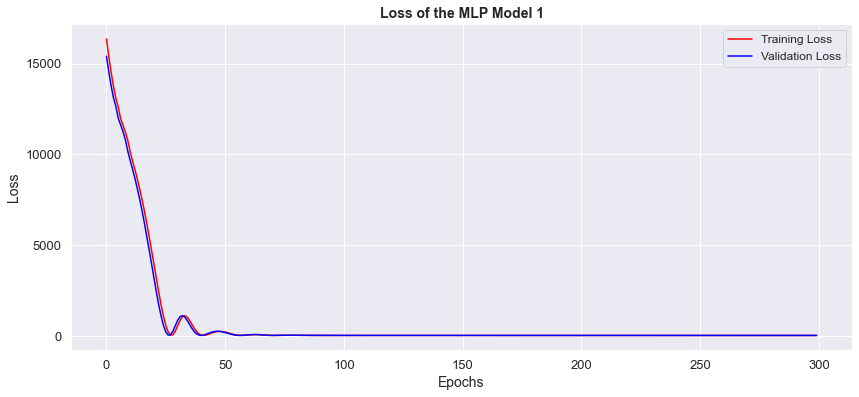

In [13]:
# Plotting the training loss and validation loss

model1_loss_df=pd.DataFrame({'Epochs':range(epochs),
                'Train_loss':model1_training_loss,
                'Val_loss':model1_validation_loss})
#sns.set_style("dark")
plt.figure(figsize=(14,6))
fig=sns.lineplot(data=model1_loss_df,x='Epochs',y='Train_loss',color = 'red')
fig=sns.lineplot(data=model1_loss_df,x='Epochs',y='Val_loss',color = 'blue')
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Loss of the MLP Model 1',weight='bold', fontsize = 14)
plt.legend(["Training Loss", "Validation Loss"], fontsize = 12)
plt.show(fig)

## Neural Network Architecture

There are 5, 6 and 1 neurons in the input, hidden and output layers respectively. The neurons other than the input and out layers are called **Hidden Layers**.

In [14]:
#make_dot(model_1(X_train), params=dict(model_1.named_parameters()))
summary(model_1, input_size=(X_train.shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 6986, 5]              55
            Linear-2              [-1, 6986, 6]              36
            Linear-3              [-1, 6986, 1]               7
Total params: 98
Trainable params: 98
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.27
Forward/backward pass size (MB): 0.64
Params size (MB): 0.00
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


# Model 1 Evaluation

In [15]:
# Comparing Actual weights and predicted weights for the test set
model1_predicted = model_1(X_test).detach().numpy()
model1_actual_predicted_weight=pd.DataFrame({'actual':y_test,'predicted':model1_predicted.flatten()})
model1_actual_predicted_weight

,actual,predicted
0,112.8,111.751381
1,100.2,106.787598
2,107.2,108.153366
3,123.7,112.814751
4,105.8,110.330482
...,...,...
1492,101.5,109.520119
1493,109.0,112.192070
1494,134.2,116.695847
1495,119.8,113.901527


## Model_1 Evaluation

In [16]:
# Model Evaluation using Mean Squared Error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
model1_MSE = mse(model1_actual_predicted_weight['actual'],model1_actual_predicted_weight['predicted'])
model1_MAE = mae(model1_actual_predicted_weight['actual'],model1_actual_predicted_weight['predicted'])
model1_MAPE = mape(model1_actual_predicted_weight['actual'],model1_actual_predicted_weight['predicted'])
print('\n\nMean Squared Error(MSE): {} \n\nRoot Mean Square Error(RMSE): {}'.format(model1_MSE,model1_MSE**0.5))
print('\n\nMean Absolute Error (MAE): {} \n\nMean Absolute Percentage Error(MAPE): {}'.format(model1_MAE,model1_MAPE))



Mean Squared Error(MSE): 29.2545604528106 

Root Mean Square Error(RMSE): 5.408748510774983


Mean Absolute Error (MAE): 4.253688635408839 

Mean Absolute Percentage Error(MAPE): 0.038198618824442546


# Model 1 Prediction

In [17]:
def predict(row, model):
    # convert row to data
    row = torch.Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    print('Predicted: %.3f' % yhat)

# Make Predictions
row = [106., 110., 103., 116.,  63.,   1.,   0.,   0.,   1., 127.] # The new data sholud be of length 8 
predict(row, model_1)

Predicted: 102.961


# MODEL2: Prediction of WEIGHT using a subset of features
The features selected are,
* Chest circumference of pig
* Abdominal circumference of pigs
* Waist circumference of pig
* The height of a pig

**The above features were selected based on correlation analysis of the entire feature set. Chest circumference, Abdominal Circumfence and Waist Circumference have high correlation leading to multicolinearity. Hence, one of them is selected for the regression analysis**

In [18]:
# Correlation matrix showing the correlation between each pair of features
cleaned_data.corr()

,Chest circumference of pig,Abdominal circumference of pigs,Waist circumference of pig,Weight measurement,Length of pig,The height of a pig,female,male,S21,S23,age in days
Chest circumference of pig,1.000000,0.832291,0.857066,0.643406,0.555667,0.443640,-0.206310,0.206310,0.174250,-0.174250,-0.052457
Abdominal circumference of pigs,0.832291,1.000000,0.827619,0.615184,0.560713,0.447656,-0.200997,0.200997,0.211088,-0.211088,-0.091251
Waist circumference of pig,0.857066,0.827619,1.000000,0.605605,0.529327,0.411785,-0.194867,0.194867,0.201123,-0.201123,-0.079258
Weight measurement,0.643406,0.615184,0.605605,1.000000,0.692095,0.433187,-0.331329,0.331329,0.326012,-0.326012,0.079378
Length of pig,0.555667,0.560713,0.529327,0.692095,1.000000,0.591246,-0.297071,0.297071,0.233412,-0.233412,-0.029379
The height of a pig,0.443640,0.447656,0.411785,0.433187,0.591246,1.000000,-0.257893,0.257893,0.148746,-0.148746,-0.034977
female,-0.206310,-0.200997,-0.194867,-0.331329,-0.297071,-0.257893,1.000000,-1.000000,-0.060930,0.060930,0.201624
male,0.206310,0.200997,0.194867,0.331329,0.297071,0.257893,-1.000000,1.000000,0.060930,-0.060930,-0.201624
S21,0.174250,0.211088,0.201123,0.326012,0.233412,0.148746,-0.060930,0.060930,1.000000,-1.000000,-0.321935
S23,-0.174250,-0.211088,-0.201123,-0.326012,-0.233412,-0.148746,0.060930,-0.060930,-1.000000,1.000000,0.321935


In [19]:
# Selection of features for prediction
selected_features=cleaned_data[['Length of pig','The height of a pig','Chest circumference of pig','age in days']]
labels=y

X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(selected_features, labels, test_size=0.3, random_state=10)
X_test_selected, X_val_selected, y_test_selected, y_val_selected = train_test_split(X_test_selected, y_test_selected, test_size=0.5, random_state=10)

# Converting numpy arrays to tensors 

X_train_selected = torch.from_numpy(X_train_selected.values.astype(np.float32))
y_train_selected = torch.from_numpy(y_train_selected.astype(np.float32))
y_train_selected = y_train_selected.view(y_train_selected.shape[0], 1)


X_val_selected=torch.from_numpy(X_val_selected.values.astype(np.float32))
y_val_selected = torch.from_numpy(y_val_selected.astype(np.float32))
y_val_selected = y_val_selected.view(y_val_selected.shape[0], 1)



X_test_selected=torch.from_numpy(X_test_selected.values.astype(np.float32))


## MLP_2 Construction

In [20]:
n_samples_selected, n_features_selected = X_train_selected.shape
#input_size = n_features


class MLP_2(torch.nn.Module):

  def __init__(self, n_features):
    super(MLP_2, self).__init__()
    self.fc1 = Linear(n_features_selected, 5) # Input layer
    self.fc2 = Linear(5, 4)          # 1st Hidden layer with 5 neurons
    self.fc3 = Linear(4, 1)          # 3rd hidden layer with 4 nerons
       

  def forward(self, x1):
    x1 = F.relu(self.fc1(x1))
    x1 = F.relu(self.fc2(x1))
    return self.fc3(x1)              # Output layer with 1 neuron

model_2 = MLP_2(n_features_selected)


In [21]:
model2_criterion = MSELoss()                         # Evaluation metric: Mean Squared Error
model2_optimizer = Adam(model_2.parameters(), lr=0.01) # Optimizer Adam
# enumerate epochs
model2_time,model2_training_loss,model2_validation_loss=[],[],[]
epochs=300
for epoch in range(epochs):                      # Number of Epochs is 300
    # clear the gradients
    model_2.train()
    model2_optimizer.zero_grad()
    # compute the model output
    yhat_selected = model_2(X_train_selected)
    # calculate loss
    model2_loss = model2_criterion(yhat_selected, y_train_selected)
    # credit assignment
    model2_loss.backward()
    # update model weights
    model2_optimizer.step()
    model2_training_loss.append(model2_loss.item())
    
    
    # MODEL VALIDATION (validation loss)
    model_2.eval()
    #val_input, val_target = ...
    model2_val_output = model_2(X_val_selected)
    model2_val_loss = model2_criterion(model2_val_output, y_val_selected)
    model2_validation_loss.append(model2_val_loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1}, Training loss = {model2_loss.item():.4f}, Validation loss = {model2_val_loss.item():.4f}')


epoch: 10, Training loss = 9101.3740, Validation loss = 8608.5000
epoch: 20, Training loss = 4499.2988, Validation loss = 4018.5100
epoch: 30, Training loss = 509.8699, Validation loss = 307.2857
epoch: 40, Training loss = 410.6371, Validation loss = 459.9130
epoch: 50, Training loss = 108.4121, Validation loss = 78.3614
epoch: 60, Training loss = 92.5690, Validation loss = 96.5649
epoch: 70, Training loss = 52.1640, Validation loss = 47.9354
epoch: 80, Training loss = 49.6415, Validation loss = 51.6011
epoch: 90, Training loss = 42.4301, Validation loss = 43.1005
epoch: 100, Training loss = 43.3072, Validation loss = 43.8920
epoch: 110, Training loss = 42.0157, Validation loss = 43.0161
epoch: 120, Training loss = 42.1059, Validation loss = 43.0463
epoch: 130, Training loss = 41.9848, Validation loss = 42.8701
epoch: 140, Training loss = 41.9247, Validation loss = 42.8399
epoch: 150, Training loss = 41.9011, Validation loss = 42.8346
epoch: 160, Training loss = 41.8649, Validation los

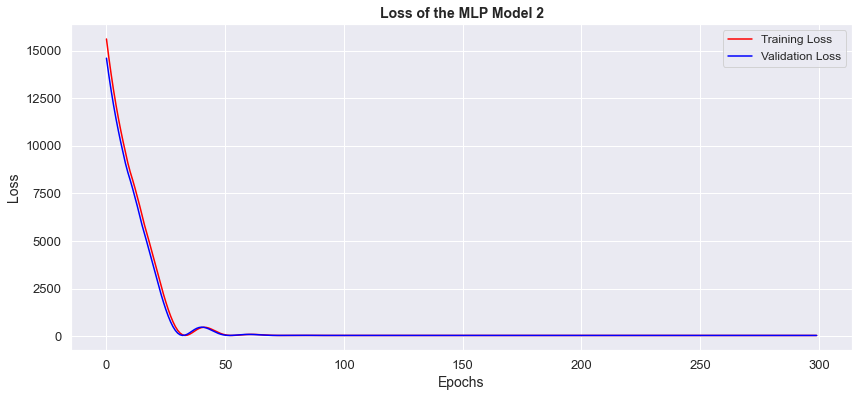

In [22]:
# Plotting the training loss and validation loss

model2_loss_df=pd.DataFrame({'Epochs':range(epochs),
                'Train_loss':model2_training_loss,
                'Val_loss':model2_validation_loss})
#sns.set_style("dark")
plt.figure(figsize=(14,6))
fig=sns.lineplot(data=model2_loss_df,x='Epochs',y='Train_loss',color = 'red')
fig=sns.lineplot(data=model2_loss_df,x='Epochs',y='Val_loss',color = 'blue')
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Loss of the MLP Model 2',weight='bold', fontsize = 14)
plt.legend(["Training Loss", "Validation Loss"], fontsize = 12)
plt.show(fig)

## Evaluation of Model 2

In [23]:
# Comparing Actual weights and predicted weights for the test set
model2_predicted = model_2(X_test_selected).detach().numpy()
model2_actual_predicted_weight=pd.DataFrame({'actual':y_test_selected,'predicted':model2_predicted.flatten()})
model2_actual_predicted_weight

,actual,predicted
0,114.2,110.839622
1,115.0,109.086426
2,100.4,113.395905
3,100.2,108.474052
4,110.4,110.833389
...,...,...
1492,105.7,111.314049
1493,113.8,112.692291
1494,111.2,109.440308
1495,110.2,108.758949


## Model_2 Evaluation

In [24]:
model2_MSE = mse(model2_actual_predicted_weight['actual'],model2_actual_predicted_weight['predicted'])
model2_MAE = mae(model2_actual_predicted_weight['actual'],model2_actual_predicted_weight['predicted'])
model2_MAPE = mape(model2_actual_predicted_weight['actual'],model2_actual_predicted_weight['predicted'])
print('\n\nMean Squared Error(MSE): {} \n\nRoot Mean Square Error(RMSE): {}'.format(model2_MSE,model2_MSE**0.5))
print('\n\nMean Absolute Error (MAE): {} \n\nMean Absolute Percentage Error(MAPE): {}'.format(model2_MAE,model2_MAPE))



Mean Squared Error(MSE): 39.290164487403686 

Root Mean Square Error(RMSE): 6.268186698512073


Mean Absolute Error (MAE): 4.963811746213782 

Mean Absolute Percentage Error(MAPE): 0.04465352326373487


## Using Model 2 for prediction

In [25]:
def predict(data, model):
    # convert row to data
    new_data = torch.Tensor([data])
    # make prediction
    yhat = model(new_data)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    print('Predicted: %.3f' % yhat)

# Make Predictions
data = [117.,  59., 103., 188.] # The new data sholud be of length 4 
predict(data, model_2)

Predicted: 112.409


# Comparative Analysis
The evaluation metrics used in assessing the two models are,
* **Mean Squared Error (MSE)**.
$$MSE = \frac{1}{N}\sum_{i=1}^{N} (Actual_{i}-Predicted_{i})^2$$


* **The Root Mean Squared Error (RMSE)**.
$$RMSE = \sqrt{ \frac{1}{N}\sum_{i=1}^{N} (Actual_{i}-Predicted_{i})^2}$$


* **Mean Absolute Error (MAE)**.
$$MAE = \frac{1}{N}\sum_{i=1}^{N} |Actual_{i}-Predicted_{i}|$$


* **Mean Absolute Percentage Error (MAPE)**.
$$MAPE = \frac{1}{N}\sum_{i=1}^{N} |\frac{Actual_{i}-Predicted_{i}}{Actual_{i}}|$$


A shown from the table below, Model1 has the least of the errors for all the evaluation metrics. Thus the errors incurred by the Model1 for the MSE, RMSE, MAE and the MAPE is the least among the two models.

Since Model1 has the least error, it is the better model for predicting the weight of the pigs.
### NOTE
Model1 uses all the features in the dataset in the modelling process.

In [26]:
compare_model1_model2 = pd.DataFrame({ 'Metrics':['MSE','RMSE','MAE','MAPE'],
                          'Model_1':[model1_MSE,model1_MSE**0.5,model1_MAE,model1_MAPE],
                         'Model_2':[model2_MSE,model2_MSE**0.5,model2_MAE,model2_MAPE]})
compare_model1_model2

,Metrics,Model_1,Model_2
0,MSE,29.254560,39.290164
1,RMSE,5.408749,6.268187
2,MAE,4.253689,4.963812
3,MAPE,0.038199,0.044654


# Miscellaneous (Showing all predictions for both model 1 and model 2)

## All Predictions for Model 1

In [27]:
# Model1 Predictions

pd.set_option("max_rows", None)
model1_actual_predicted_weight

,actual,predicted
0,112.8,111.751381
1,100.2,106.787598
2,107.2,108.153366
3,123.7,112.814751
4,105.8,110.330482
5,147.0,117.326683
6,115.7,109.872658
7,116.0,111.398308
8,106.4,112.331398
9,111.5,110.874619


In [28]:
# Model 2 Predictions
model2_actual_predicted_weight

,actual,predicted
0,114.2,110.839622
1,115.0,109.086426
2,100.4,113.395905
3,100.2,108.474052
4,110.4,110.833389
5,118.3,113.092316
6,100.1,110.945938
7,115.3,115.638672
8,113.2,112.062576
9,110.8,106.032089
